In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# RNN for genetic circuits

Following https://docs.kidger.site/equinox/examples/train_rnn/

# Imports

In [96]:
import math
from functools import partial

import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import optax  # https://github.com/deepmind/optax
import equinox as eqx
jax.config.update('jax_platform_name', 'cpu')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from synbio_morpher.utils.data.data_format_tools.common import write_json
from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence
from synbio_morpher.utils.misc.string_handling import convert_liststr_to_list
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.results.analytics.naming import get_true_names_analytics, get_true_interaction_cols

sns.set_context('paper')
sns.set_style('whitegrid')


# Load data

In [97]:

fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
data = pd.read_csv(fn)
data.drop(columns=['Unnamed: 0'], inplace=True)

# Hyperparameters

In [98]:
BATCH_SIZE = 128
N_BATCHES = 1400
N_HEAD = 5
TOTAL_DS = BATCH_SIZE * N_BATCHES
# TOTAL_DS = 50000
TRAIN_SPLIT = int(0.8 * TOTAL_DS)
TEST_SPLIT = TOTAL_DS - TRAIN_SPLIT
LEARNING_RATE = 1e-3
# LEARNING_RATE_SCHED = 'cosine_decay'
# LEARNING_RATE_SCHED = 'constant'
WARMUP_EPOCHS = 20
L2_REG_ALPHA = 0.01
EPOCHS = 1400
PRINT_EVERY = EPOCHS // 20
SEED = 0
INPUT_SPECIES = ['RNA_1', 'RNA_2']

# RNN Architecture
HIDDEN_SIZE = 64


n_samples = len(data['sample_name'].unique())

rng = jax.random.PRNGKey(SEED)
# rng, subkey = jax.random.split(rng, 2)

# Make inputs & outputs

In [99]:
def dataloader(arrays, batch_size):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays), 'The '
    indices = np.arange(dataset_size)
    while True:
        perm = np.random.permutation(indices)
        start = 0
        end = batch_size
        while end <= dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size


In [100]:
def custom_round(x, base=5):
    return base * round(x/base)


def convert_to_scientific_exponent(x, numerical_resolution: dict):
    exp_not = f'{x:.0e}'.split('e')
    resolution = numerical_resolution[int(exp_not[1])]
    base = int(10 / resolution)
    pre = custom_round(int(exp_not[0]), base=base)
    return int(exp_not[1]) + pre / 10


def drop_duplicates_keep_first_n(df, column, n):
    """ GCG """
    indices = df[df.duplicated(subset=column, keep=False)].groupby(
        column).head(n).index
    all_duplicates_indices = df[df.duplicated(subset=column, keep=False)].index
    to_drop = list(set(all_duplicates_indices) - set(indices))
    df2 = df.drop(to_drop)
    return df2


def bin_array(array, n_bins):
    """ Bard AI

    Bins a NumPy array of floats into n bins of a specific size.

    Args:
      array: A NumPy array of floats.
      n_bins: The number of bins.

    Returns:
      A NumPy array of integers, where each integer represents the bin that the
      corresponding element in the input array belongs to.
    """

    bins = np.linspace(array.min(), array.max(), n_bins + 1)
    bin_indices = np.digitize(array, bins) - 1
    return bin_indices


vectorized_convert_to_scientific_exponent = np.vectorize(
    convert_to_scientific_exponent)
filt = data['sample_name'].isin(INPUT_SPECIES)
numerical_resolution = 2

# Balance the dataset
df = drop_duplicates_keep_first_n(data[filt], get_true_interaction_cols(data, 'energies', remove_symmetrical=True), n=200)
df['sensitivity'] = df['sensitivity'].round(np.abs(int(f'{df["sensitivity"].min():.0e}'.split('e')[1]))-1)
df['fold_change'] = df['fold_change'].round(3)
df = drop_duplicates_keep_first_n(df, column='sensitivity', n=200)


In [101]:

xs = np.where(
    df.iloc[:TOTAL_DS][['fold_change'] * 5] < 1,
    df.iloc[:TOTAL_DS][['initial_steady_states', 'initial_steady_states',
                        'max_amount', 'min_amount', 'steady_states']].values,
    df.iloc[:TOTAL_DS][['initial_steady_states', 'initial_steady_states',
                        'min_amount', 'max_amount', 'steady_states']].values
)
ts = np.repeat(np.arange(xs.shape[-1])[None, :], repeats=TOTAL_DS, axis=0)
# ts[:, -1] = ts[:, -1] + np.where(df['response_time'].iloc[:TOTAL_DS] == np.inf, df[df['response_time']
#                                  != np.inf]['response_time'].max(), df['response_time'].iloc[:TOTAL_DS])
xs = np.concatenate([ts[:, :, None], xs[:, :, None]], axis=2)

ys = df[get_true_interaction_cols(
    data, 'energies', remove_symmetrical=True)].iloc[:TOTAL_DS].values
ys = bin_array(ys, n_bins=N_HEAD)

if xs.shape[0] < TOTAL_DS:
    print(
        f'WARNING: The filtered data is not as large as the requested total dataset size: {xs.shape[0]} vs. requested {TOTAL_DS}')

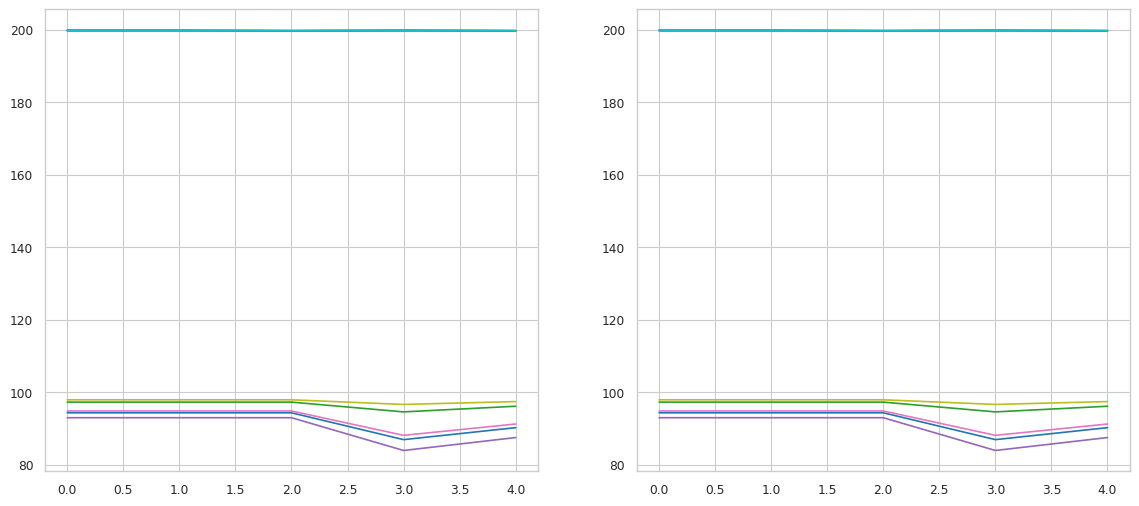

In [102]:
plt.figure(figsize=(7*2, 6))
ax = plt.subplot(1,2,1)
plt.plot(xs[:10, :, 1].T)
ax = plt.subplot(1,2,2)
plt.plot(xs[:10, :, 0].T, xs[:10, :, 1].T, )

Text(0.5, 0.98, 'Balance of values in dataset')

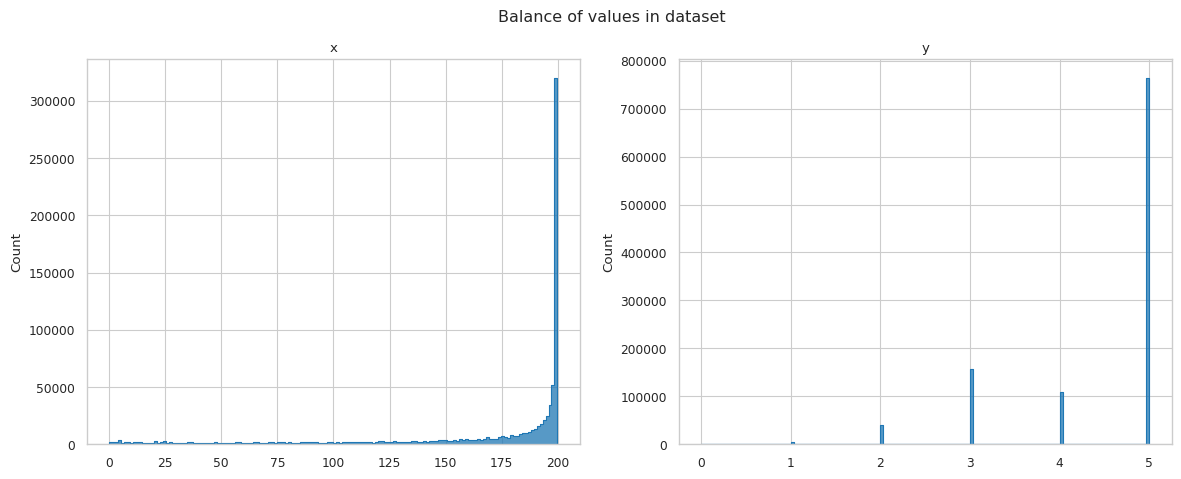

In [103]:
plt.figure(figsize=(2*7, 5))
ax = plt.subplot(1,2,1)
sns.histplot(x=xs[:, :, 1].flatten(), element='step', bins=150)
plt.title('x')
ax = plt.subplot(1,2,2)
sns.histplot(x=ys.flatten(), element='step', bins = 150)
plt.title('y')

plt.suptitle('Balance of values in dataset')


# Model

In [104]:
class RNN(eqx.Module):
    hidden_size: int
    cell: eqx.Module
    linear: eqx.nn.Linear
    bias: jax.Array

    def __init__(self, in_size, out_size, hidden_size, *, key):
        ckey, lkey = jrandom.split(key)
        self.hidden_size = hidden_size
        self.cell = eqx.nn.GRUCell(in_size, hidden_size, key=ckey)
        self.linear = eqx.nn.Linear(hidden_size, out_size, use_bias=False, key=lkey)
        self.bias = jnp.zeros(out_size)

    def __call__(self, input):
        hidden = jnp.zeros((self.hidden_size,))

        def f(carry, inp):
            return self.cell(inp, carry), None

        out, _ = lax.scan(f, hidden, input)
        # sigmoid because we're performing binary classification
        return jax.nn.sigmoid(self.linear(out) + self.bias)

# Train

In [105]:
# def main(
#     dataset_size=10000,
#     batch_size=32,
#     learning_rate=3e-3,
#     steps=200,
#     hidden_size=16,
#     depth=1,
#     seed=5678,
# ):

data_key, model_key = jrandom.split(jrandom.PRNGKey(SEED), 2)
iter_data_train = dataloader((xs[:], ys[:]), BATCH_SIZE)
iter_data_test = dataloader((xs[-TRAIN_SPLIT:], ys[-TRAIN_SPLIT:]), BATCH_SIZE)

model = RNN(in_size=xs.shape[-1], out_size=ys.shape[-1]
            * N_HEAD, hidden_size=HIDDEN_SIZE, key=model_key)


def cross_entropy(y, pred_y, num_classes: int):
    one_hot_actual = jax.nn.one_hot(y, num_classes=num_classes)
    return optax.softmax_cross_entropy(pred_y, one_hot_actual).sum()


@eqx.filter_value_and_grad
def compute_loss(model, x, y):
    pred_y = jax.vmap(model)(x)
    return cross_entropy(y, pred_y.reshape(tuple([pred_y.shape[0], y.shape[-1], N_HEAD])), num_classes=N_HEAD)
    # Trains with respect to binary cross-entropy
    # return -jnp.mean(y * jnp.log(pred_y) + (1 - y) * jnp.log(1 - pred_y))

# Important for efficiency whenever you use JAX: wrap everything into a single JIT


# @eqx.filter_jit
def make_step(model, x, y, opt_state, optim):
    loss, grads = compute_loss(model, x, y)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state


def eval(model, x, y):
    """ Return the average of loss and accuracy on validation data """
    pred_y = jax.vmap(model)(x)
    pred_y = pred_y.reshape(tuple([pred_y.shape[0], y.shape[-1], N_HEAD]))
    loss = cross_entropy(y, pred_y, num_classes=N_HEAD)
    acc = jnp.mean(
        jnp.argmax(pred_y, axis=-1
                   ) == ys)
    # acc = (num_correct / dataset_size).item()
    return acc / len(x), loss / len(x)


def train(model, iter_data_train, iter_data_test,
          optim, opt_state, epochs,
          save_every: int = 50):
    saves = {}
    for e in range(epochs):

        train_loss_total = 0
        test_loss = 0
        test_accuracy = 0
        for (x_batch, y_batch), (x_test, y_test) in zip(iter_data_train, iter_data_test):
            loss, model, opt_state = make_step(
                model, x_batch, y_batch, opt_state, optim)
            acc_eval, loss_eval = eval(model, x_test, y_test)
            train_loss_total += loss
            test_loss += loss_eval
            test_accuracy += acc_eval

        if np.mod(e, save_every) == 0:
            saves[e] = {
                'params': model.linear.weight,
                'train_loss': train_loss_total / len(iter_data_train),
                'val_loss': test_loss / len(iter_data_test),
                'val_accuracy': test_accuracy / len(iter_data_test)
            }
            print(
                f'Epoch {e} / {epochs} -\t\t Train loss: {saves[e]["train_loss"]}\tVal loss: {saves[e]["val_loss"]}\tVal accuracy: {saves[e]["val_accuracy"]}')
    return model, saves


optim = optax.adam(LEARNING_RATE)
opt_state = optim.init(model)

model, saves = train(model, iter_data_train, iter_data_test,
                     optim, opt_state, epochs=EPOCHS, save_every=PRINT_EVERY)
# saves = {}
# for step, (xs, ys), (x_test, y_test) in zip(range(EPOCHS), iter_data_train, iter_data_test):
#     loss, model, opt_state = make_step(model, xs, ys, opt_state)
#     acc_eval, loss_eval = eval(model, x_test, y_test)
#     loss = loss.item()
#     saves[step] = {
#         'loss': loss / len(xs),
#         'acc': acc_eval,
#         'test_loss': loss_eval,
#         'linear_w': np.array(model.linear.weight),
#         'cell_w': np.array(model.cell.weight_hh)
#     }
#     if np.mod(step, PRINT_EVERY) == 0:
#         print(f"step={step}, loss={loss / len(xs)}, acc={acc_eval}")

TypeError: eq got incompatible shapes for broadcasting: (128, 6), (179200, 6).

Text(0.5, 1.0, 'test loss')

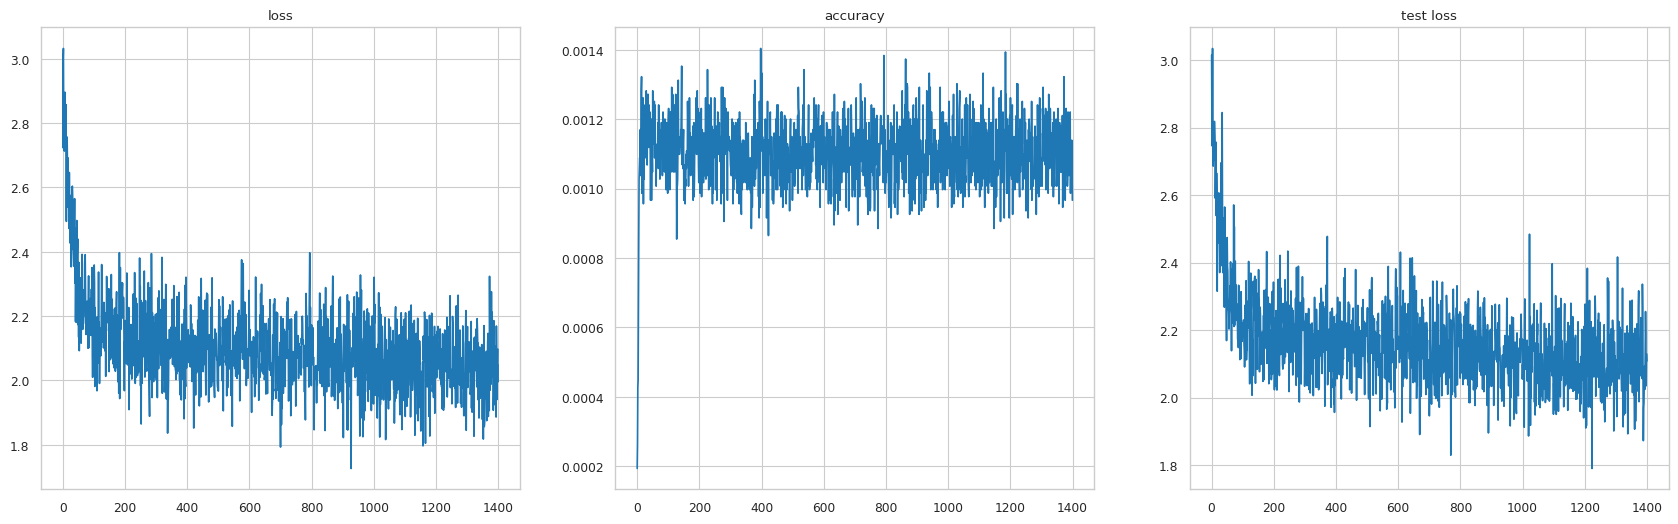

In [ ]:
plt.figure(figsize=(7*3, 6))
ax = plt.subplot(1,3,1)
plt.plot([v['loss'] for v in saves.values()])
plt.title('loss')
ax = plt.subplot(1,3,2)
plt.plot([v['acc'] for v in saves.values()])
plt.title('accuracy')
ax = plt.subplot(1,3,3)
plt.plot([v['test_loss'] for v in saves.values()])
plt.title('test loss')

# Visualise

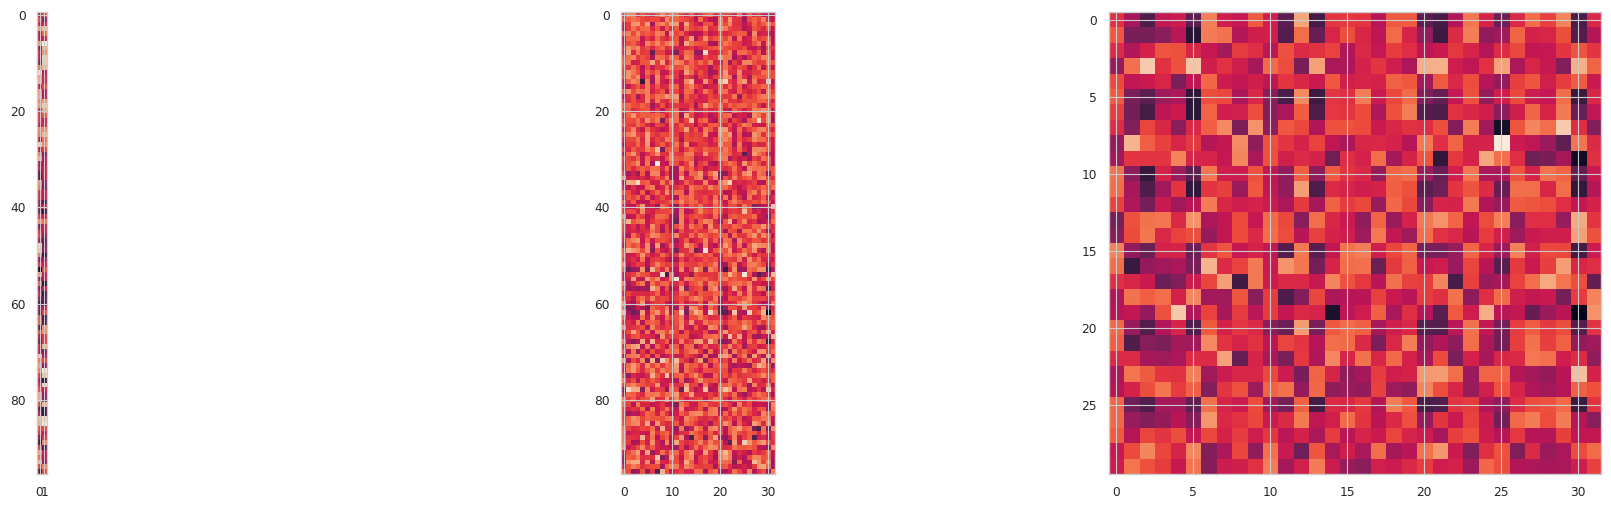

In [ ]:

plt.figure(figsize=(8*3, 6))
ax = plt.subplot(1,3,1)
plt.imshow(model.cell.weight_ih)
ax = plt.subplot(1,3,2)
plt.imshow(model.cell.weight_hh)
ax = plt.subplot(1,3,3)
plt.imshow(model.linear.weight)



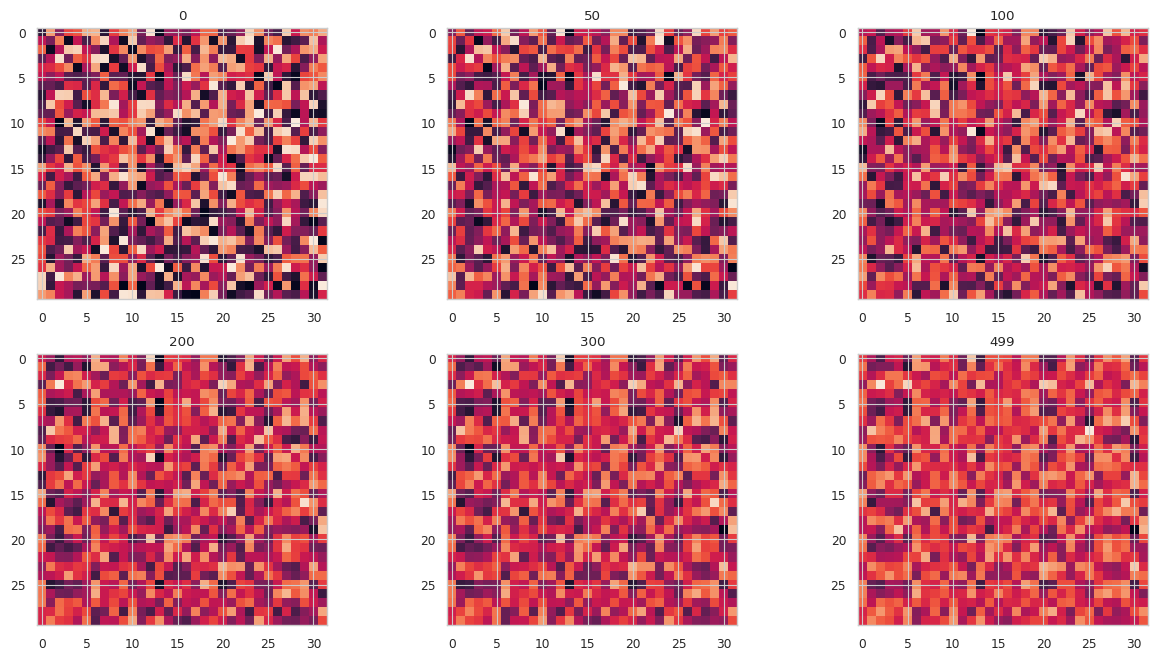

In [ ]:

chosen = [0, 50, 100, 200, 300, 499]
rows = int(np.ceil(np.sqrt(len(chosen))))
cols = int(np.ceil(np.sqrt(len(chosen))))
plt.figure(figsize=(5*rows, 4*cols))
for i, s in enumerate(chosen):
    ax = plt.subplot(rows, cols, i+1)
    plt.imshow(saves[s]['linear_w'])
    plt.title(s)